In [72]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


**Nota 1**: El ejercicio propuesto es similar a los ejercicios de clasificación visto en clase, por lo que es importante que documentéis y expliquéis adecuadamente (con vuestras palabras) los procesos llevados a cabo en el ejercicio. No hacerlo puede llegar a penalizar hasta 1 punto en la calificación final.

**Nota 2**: Cualquier cálculo adicional a los vistos en clase (visualizaciones, nuevas características añadidas al modelo...) será valorado positivamente en la calificación.

## 0. Imports


In [73]:
import pandas as pd

In [74]:
!wget https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/datos_twitter_master.tsv
import sys
!{sys.executable} -m pip install contractions
!pip install spacy==3.2.1
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')
nltk.download('punkt')

--2024-05-14 19:55:26--  https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/datos_twitter_master.tsv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/datos_twitter_master.tsv [following]
--2024-05-14 19:55:26--  https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/datos_twitter_master.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113587 (111K) [text/plain]
Saving to: ‘datos_twitter_master.tsv.1’

datos_twitter_maste 100%[===================>] 110.92K  --.-KB/s    in 0.02s   

2024-05-14 19:55:26 (5.43 MB/s) - ‘da

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import contractions
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [76]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [77]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

En primer lugar vamos a ver el tamaño de nuestro dataset, donde podemos observar que el dataset tiene 47692 documentos

In [78]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))

Tenemos un conjunto de 47692 documentos


Vamos a revisar las categorías del dataset. Inicialmente, podemos observar que se trata de un dataset desbalanceado, ya que hay más instancias con el valor 1 que con el valor 0. Es importante destacar que cuando la categoría tiene el valor 1, indica que el tweet contiene contenido de odio, mientras que el valor 0 indica lo contrario

In [79]:
print(dataset["cyberbullying"].value_counts())

cyberbullying
1    39747
0     7945
Name: count, dtype: int64


Será importante hacer su debido tratamiento sobre este desabalanceo que se presenta. Antes de esto, veamos a continuación un ejemplo donde se nos muestra algunos ejemplos de tweets con mensajes catalogados como cyberbulling.

In [80]:
dataset[dataset.cyberbullying == 1].sample(5).tweet_text.to_list()

['Your twitter handle uses gay slang but you tweet blatant homophobia and content that makes jokes about male rape. Are you really that out of touch?',
 '@FarooqSumar @NafeezAhmed @MaxBlumenthal As this Palestinian makes clear, they are Egyptians and Saudis and that Arabs must destroy Jews....',
 'Anyway, today a colleague showed me a picture of a woman in a bikini and said, "No wonder there\'s rape in this world!" As if I\'m someone to joke and laugh about raping women with because he knows I\'m gay. I wonder how he\'ll raise his newborn daughter.',
 'RT @lexi4prez: this is why Pepsi is TRASH. how are you gonna have a nasty product and shitty ads for it https://t.co/q0hec5VAze',
 'omg omg omg omg omg SHUT THE FUCK UP YOU STUPID FUCKING UGLY DUMB NIGGER BARBIE DOLL!!!']

Y a continuación tendremos ejemplos de tweets que se clasifican como No Cyberbulling.

In [81]:
dataset[dataset.cyberbullying == 0].sample(5).tweet_text.to_list()

["This is why this show is ridiculous - it's not about the cooking...it's about the game playing. #mkr #whogivesa1",
 '#mkr NOOOOO!!! I wanted Kat and Andre to lose!!!',
 '@Lincoln_WI definitely, also thinking of specialised classes for our timetable',
 'Meu isso é bullying, não veio queijo em meu cheese bacon.',
 "@NoZzzander Eddie Izzard is a man, sorry that he doesn't fit the only narrow gender binary your feeble brain can process"]

Ahora, lo que haremos será revisar un grafico de dispersión donde podamos visualizar el numero de caracteres que hay por tweet. 

In [82]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

<Figure size 1400x1200 with 0 Axes>

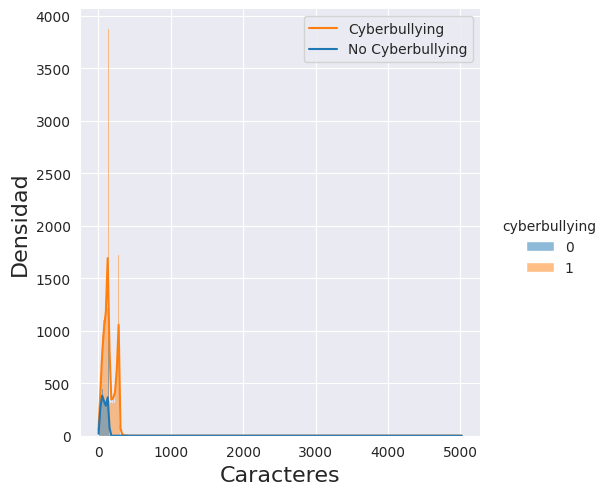

In [83]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["Cyberbullying", "No Cyberbullying"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

Podemos observar que hay muchos datos atípicos, ya que encontramos tweets clasificados como "no odio" que tienen hasta 5000 caracteres. Al visualizar los datos en un gráfico, notamos que los tweets atípicos están en el rango de 500 a 5000 caracteres. Ante esta anomalía, se ha decidido eliminar los tweets que tienen más de 300 caracteres. A continuación, analicemos qué sucede.

In [84]:
dataset2 = dataset[dataset['char_len'] <= 300]

<Figure size 1400x1200 with 0 Axes>

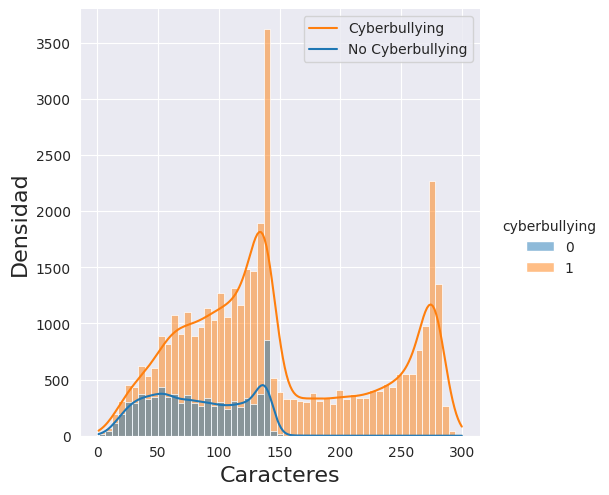

In [85]:
# Importamos las librerías matplotlib y seaborn:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset2, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["Cyberbullying", "No Cyberbullying"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

Del procesamiento anterior, se observa una estructura más organizada. En primer lugar, no se detectan datos atípicos. Además, se destaca un patrón interesante: los tweets con más de 150 caracteres tienden a pertenecer a la categoría de "tweet con odio". Finalmente, es relevante señalar que la moda, es decir, la longitud de caracteres que más se repite en el dataset, es de 150 caracteres. Por otro lado, es importante mencionar que en la categoría "Tweets sin odio", la mayoría de los tweets presentan una longitud mayor que menor. 


Después de esta depuración, a continuación se muestra cuántos documentos quedan en el dataset final.

In [86]:
print("Tenemos un conjunto de {} documentos".format(len(dataset2)))

Tenemos un conjunto de 47536 documentos


Ahora, lo que haremos será un análisis de los contenidos en los tweets

In [87]:
from wordcloud import WordCloud

txt_cat0 = ",".join(dataset2[dataset2.cyberbullying==0].tweet_text.to_list())
txt_cat1 = ",".join(dataset2[dataset2.cyberbullying==1].tweet_text.to_list())

In [88]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True)

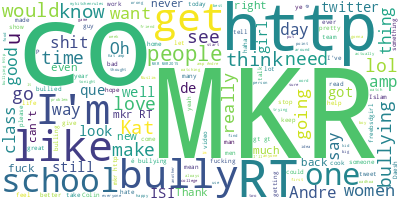

In [89]:
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

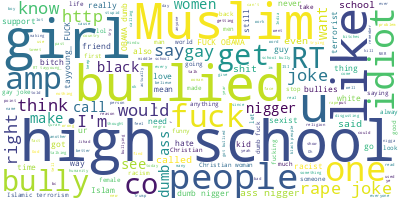

In [90]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

De los resultados anteriores, podemos encontrar hallazgos interesantes en los tweets con la categoría "No Ciberbullying":

Se observa una alta repetición de palabras como "Bully", "School", entre otras, así como la presencia de URL. Sería pertinente analizar detenidamente este tipo de palabras en un model

.
Por otro lado, en los tweets con la categoría "Ciberbullying", se destaca lo siguiente:

Es sorprendente que las palabras "Girl" o "Muslim" sean predominantes, lo que sugiere una fuerte tendencia hacia tweets que contienen comentarios contra las mujeres o alguna religión, en este caso, la musulmana. Es importante destacar que la palabra "School" también es prominente en esta categoría, lo que sugiere que no sería una buena palabra para incluir en el moelo."



## 3. Preprocesado y Normalización

Ahora procederemos a transformar todas las palabras en minúsculas con el objetivo de reducir la dimensionalidad del dataset. Esto nos permitirá identificar y eliminar posibles duplicados que puedan estar presentes, además de facilitar la tokenización del texto. También eliminaremos cualquier espacio adicional que pueda estar presente en los tweets.


In [91]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

In [92]:
dataset2["normalized"] = dataset2["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset2["normalized"] = dataset2["normalized"].progress_apply(lambda x: texto_to_lower(x))

  0%|          | 0/47536 [00:00<?, ?it/s]

  0%|          | 0/47536 [00:00<?, ?it/s]

In [93]:
dataset2["normalized"].iloc[0]

'in other words #katandandre, your food was crapilicious! #mkr'

Luego, procederemos a eliminar las contracciones con el fin de estandarizar los textos, lo que facilitará el análisis y la comparación de palabras al asegurarnos de que todas estén escritas de la misma manera. Además, al eliminar las contracciones, se reduce la cantidad de palabras únicas en el corpus, lo que puede ayudar a reducir la dimensionalidad del conjunto de datos.

In [94]:
!pip install contractions

In [95]:
import contractions
# Reemplazar contracciones y slang en inglés usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    # Divide el texto
    for t in text.split():
        # Aplica la función fix en cada sección o token del texto buscando contracciones y slang
        expanded_words.append(contractions.fix(t, slang = True))
    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [96]:
dataset2["normalized"] = dataset2["normalized"].progress_apply(lambda x: replace_contraction(x))

  0%|          | 0/47536 [00:00<?, ?it/s]

In [97]:
dataset2

,tweet_text,cyberbullying,char_len,normalized
0,"In other words #katandandre, your food was cra...",0,61,"in other words #katandandre, your food was cra..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,why is #aussietv so white? #mkr #theblock #ima...
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,@xochitlsuckkks a classy whore? or more red ve...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,"@jason_gio meh. :p thanks for the heads up, bu..."
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,@rudhoeenglish this is an isis account pretend...
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",1,234,"black people are not expected to do anything, ..."
47688,Turner did not withhold his disappointment. Tu...,1,276,turner did not withhold his disappointment. tu...
47689,I swear to God. This dumb nigger bitch. I have...,1,104,i swear to god. this dumb nigger bitch. i have...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,1,90,yea fuck you rt @therealexel: if you are a nig...


Una vez completada la normalización del dataset, procederemos a eliminar las observaciones que contengan tweets repetidos.

Veamos a continuacion el número total de documentos

In [98]:
print("Tenemos un conjunto de {} documentos".format(len(dataset2)))

Tenemos un conjunto de 47536 documentos


Y veamos en este punto el total de documentos duplicados 

In [99]:
print("Existen {} documentos duplicadas".format(np.sum(dataset2.duplicated(subset=["normalized"]))))

Existen 1706 documentos duplicadas



Veamos finalmente, después del tratamiento de duplicados, cuántos documentos quedan en el dataset final.

In [100]:
# Quitaremos todos los duplicados
dataset2 = dataset2.drop_duplicates(subset=["normalized"])
print("Después de quitar duplicados tenemos un conjunto de {} documentos".format(dataset2.shape[0]))


Después de quitar duplicados tenemos un conjunto de 45830 documentos



Una vez completada la eliminación de duplicados, procederemos con el proceso de normalización. En este caso, aplicaremos algunas convenciones específicas. En primer lugar, normalizaremos las URLs (tokens que comienzan por "https://") reemplazándolas con la palabra "URL". Luego, cambiaremos las menciones de Twitter (tokens que comienzan por "@") por "MENCION", y los números serán reemplazados por "NUM". Además, durante este proceso, llevaremos a cabo la tokenización, que consiste en dividir el texto en las palabras que componen el tweet.

In [101]:
# Tokenizador
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"):
            palabras[i] = "MENTION"
        elif palabras[i].isdigit():
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

In [102]:
dataset2["normalized"] = dataset2["normalized"].apply(lambda x: normalizar_tokens(x))

Vemos a continuación el proceso realizado 

In [103]:
dataset2["normalized"].iloc[1782]

'here we go ! come on ! #mkr'

Por último, llevamos a cabo la lematización y la eliminación de puntuación y stopwords. La lematización es un paso crucial, ya que nos permite obtener el lema de las palabras en un documento, lo que resulta en una reducción de la dimensionalidad y mejora de los resultados de búsqueda. Esta uniformización de las palabras facilita que el modelo detecte patrones y mejora su capacidad predictiva al categorizar tweets con contenido de odio. Además, la eliminación de puntuación y stopwords se realiza porque estos elementos no aportan información relevante para el entrenamiento del modelo. Por el contrario, pueden introducir ruido y distorsiones en el modelo, lo que reduce su capacidad predictiva.



In [104]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

In [105]:
dataset2["preprocessed_text"] = dataset2["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

  0%|          | 0/45830 [00:00<?, ?it/s]

In [106]:
dataset2["preprocessed_text"].iloc[1900]

'really bad thing know blackmilk swim fit well super comfy really really bad'

Una vez procesado el texto, vamos a rehacer los word clouds para interpretar mejor el contenido de éste y visualizar el correcto funcionamiento del proceso:

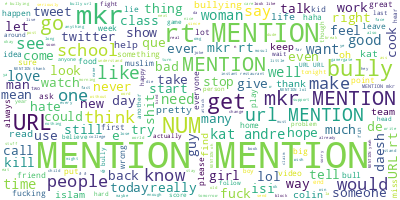

In [107]:
txt_cat0 = ",".join(dataset2[dataset2.cyberbullying==0].preprocessed_text.to_list())
txt_cat1 = ",".join(dataset2[dataset2.cyberbullying==1].preprocessed_text.to_list())
#
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

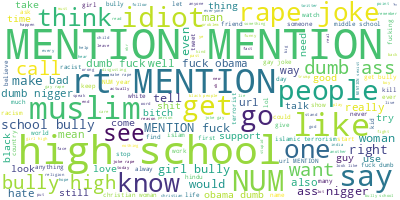

In [108]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()


Los wordclouds muestran que en la categoría de tweets con odio (segundo WordCloud), las palabras "School" y "Muslim" destacan notablemente. Sería interesante considerar la inclusión de estas características en el modelo en etapas posteriores, para observar cómo el modelo las incorpora y el impacto que tienen en su desempeño


A continuación, revisamos la frecuencia de aparición de estas características en cada documento y agregamos una columna al dataset con esta información. Como se mencionó anteriormente, esto proporcionará información valiosa al modelo.

In [109]:
def token_appearance(document, token = "school"):
  return len([x for x in document.split() if x == token])

In [110]:
dataset2["num_School"] = dataset2["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="school"))
dataset2["num_Muslim"] = dataset2["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="muslim"))

  0%|          | 0/45830 [00:00<?, ?it/s]

  0%|          | 0/45830 [00:00<?, ?it/s]

In [111]:
dataset2

,tweet_text,cyberbullying,char_len,normalized,preprocessed_text,num_School,num_Muslim
0,"In other words #katandandre, your food was cra...",0,61,"in other words #katandandre , your food was cr...",word katandandre food crapilicious mkr,0,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,why is #aussietv so white ? #mkr #theblock #im...,aussietv white mkr theblock imacelebrityau tod...,0,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,MENTION a classy whore ? or more red velvet cu...,MENTION classy whore red velvet cupcake,0,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,"MENTION meh . :p thanks for the heads up , but...",MENTION meh thank head concerned another angry...,0,0
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,MENTION this is an isis account pretending to ...,MENTION isis account pretend kurdish account l...,0,0
...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",1,234,"black people are not expected to do anything ,...",black people expect anything depend anything y...,0,0
47688,Turner did not withhold his disappointment. Tu...,1,276,turner did not withhold his disappointment . t...,turner withhold disappointment turner call cou...,0,0
47689,I swear to God. This dumb nigger bitch. I have...,1,104,i swear to god . this dumb nigger bitch . i ha...,swear god dumb nigger bitch get bleach hair re...,0,0
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,1,90,yea fuck you rt MENTION : if you are a nigger ...,yea fuck rt MENTION nigger fucking unfollow fu...,0,0


In [112]:
dataset2[dataset2['num_Muslim'] == 1]

,tweet_text,cyberbullying,char_len,normalized,preprocessed_text,num_School,num_Muslim
85,"@AMohedin Even Pickthall, who is an Englishman...",0,69,"MENTION even pickthall , who is an englishman ...",MENTION even pickthall englishman muslim convert,0,1
152,@buellerishere I've watched the ISIS guys argu...,0,118,MENTION i have watched the isis guys argue wit...,MENTION watch isis guy argue saudi muslim scho...,0,1
860,RT @RavenHUWolf: University of #Texas-#Arlingt...,0,139,rt MENTION : university of #texas - #arlington...,rt MENTION university texas arlington muslim s...,0,1
1151,@jncatron @PFLP_ps Less than 1% of Muslims are...,0,140,MENTION MENTION less than NUM % of muslims are...,MENTION MENTION less NUM muslims kill israelis...,0,1
1275,@SirajZarook Stop lying. My Hadiths come for t...,0,122,MENTION stop lying . my hadiths come for the m...,MENTION stop lie hadith come muslim students a...,0,1
...,...,...,...,...,...,...,...
44129,all muslim niggers hate the sea or water takin...,1,139,all muslim niggers hate the sea or water takin...,muslim nigger hate sea water take shower bad w...,0,1
44655,Fuck allah and his goat. Same for dumb gansta ...,1,130,fuck allah and his goat . same for dumb gansta...,fuck allah goat dumb gansta nigger rapper need...,0,1
44939,Blacks are not a minority in the UK and they t...,1,191,blacks are not a minority in the uk and they t...,black minority uk think allow anything want bl...,0,1
45822,"@AwZaynEatMe you dumb bitch, black isn't a col...",1,115,"MENTION you dumb bitch , black is not a colour...",MENTION dumb bitch black colour shade white mu...,0,1


## 4. Vectorización


Ahora procederemos con el proceso de vectorización, que implica convertir los datos de texto en vectores numéricos para su procesamiento posterior. En la siguiente función, especificamos que no deseamos realizar un procesamiento adicional de los datos, ya que este se ha llevado a cabo anteriormente. Además, queremos que se consideren tanto unigramas, bigramas como trigramas, y establecemos que los elementos que aparezcan en menos del 0.005 de los documentos no deben ser considerados. Estos parámetros están diseñados para limitar el tamaño de nuestros vectores y optimizar el proceso de vectorización.

In [113]:
vectorizador = TfidfVectorizer(lowercase = False,
                               ngram_range = (1,3),
                               min_df = 0.005)

Aquí me entrenará el modelo de vectorización y también me va a transformar mis vectores 

In [114]:
vector_data = vectorizador.fit_transform(dataset2["preprocessed_text"])

El resultado, es que mi vector_data va a ser en conjunto una matriz de 45830 documentos con 408 características 

In [115]:
vector_data

<45830x408 sparse matrix of type '<class 'numpy.float64'>'
	with 379758 stored elements in Compressed Sparse Row format>


Ahora procederé a agregar al vector_data las características adicionales que fueron calculadas previamente, que incluyen el número de veces que aparece la palabra "School" y el número de veces que aparece la palabra "Muslim".

In [116]:
extra_features = dataset2[["num_School", "num_Muslim"]]

Utilizamos el siguiente metodo sp.sparse, el cual va a tomar es un conjunto de datos en formato CSR y un conjunto de datos que quiero unir y me lo va a devolver en formato CSR 

In [117]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = dataset2["cyberbullying"].values.astype(np.float32)
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

In [118]:
vector_data

<45830x408 sparse matrix of type '<class 'numpy.float64'>'
	with 379758 stored elements in Compressed Sparse Row format>

Será nuestra matriz X la que tendrá todas las caracterisiticas que utilizaré para entrenar el modelo

In [119]:
X

<45830x410 sparse matrix of type '<class 'numpy.float64'>'
	with 390274 stored elements in Compressed Sparse Row format>

## 5. Entrenamiento y evaluación de modelos



Ahora vamos a introducir esta matriz de características (X) en el flujo de entrenamiento y validación del clasificador. En primer lugar, realizaremos la división del conjunto de datos en entrenamiento y prueba, estratificando por la etiqueta y.

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,
                                                    random_state=0,
                                                    stratify = y)
print(X_train.shape)
print(X_test.shape)

(34372, 410)
(11458, 410)


Como recordarán, anteriormente observamos un desbalance en nuestros datos, con más observaciones pertenecientes a la categoría de "tweet con odio" que a la contraria. Para abordar este problema, utilizaremos la librería SMOTE. Esta herramienta nos ayudará a equilibrar la distribución de clases en nuestro conjunto de datos generando de manera sintética nuevos ejemplos de las clases minoritarias. Es fundamental aplicar el rebalanceo únicamente en los datos de entrenamiento. Esto se debe a que si evaluamos el modelo en un conjunto de datos con una distribución diferente, no estaríamos evaluando el modelo de manera precisa
 

In [121]:
# Cargamos
from imblearn.over_sampling import SMOTE
# Creamos objetos
sm = SMOTE(random_state=42)
# Retransformamos
X_res, y_res = sm.fit_resample(X_train, y_train)

Una vez realizado esto, podemos ver que tenemos el mismo numero de muestras en las dos categorias 

In [122]:
np.array(np.unique(y_res, return_counts=True)).T

array([[0.0000e+00, 2.8422e+04],
       [1.0000e+00, 2.8422e+04]])


A continuación, se presenta una función que será utilizada para evaluar diferentes modelos. Se empleará StratifiedKFold para evaluar la calidad del modelo mediante un Cross Validation Score.

In [123]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un StratifiedKFold
          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [124]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30 )), # LogisticRegression(random_state=30)
         ("GaussianNB",GaussianNB()) # GaussianNB
         #("DecisionTree",DecisionTreeClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
Logistic: 0.874094 (0.000940) 
Metric: accuracy , KFold 
GaussianNB: 0.800964 (0.002282) 


([array([0.87430733, 0.87483508, 0.87421937, 0.87228428, 0.87482407]),
  array([0.80191749, 0.80420442, 0.79716774, 0.80051016, 0.80102041])],
 ['Logistic', 'GaussianNB'])

In [125]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("DecisionTree", DecisionTreeClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_res.toarray(), y_res)

Metric: accuracy , KFold 
DecisionTree: 0.887235 (0.001978) 


([array([0.88626968, 0.88723722, 0.88415868, 0.88996394, 0.8885468 ])],
 ['DecisionTree'])

De estos tres modelos podemos observar que el modelo que mejor se ajusta es el de arboles de decisión. Por lo que a continuación haremos un ajuste de hiperparámetros 

In [127]:
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Luego entrenamos el modelo y hacemos un print del mejor resultado

In [130]:
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_result = grid_search.fit(X_res, y_res)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.888203 usando los parámetros {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


Entrenamos el modelo y hacemos un "print" del mejor resultado:

In [133]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=DecisionTreeClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 2)
model.fit(X_res, y_res)

DecisionTreeClassifier()

Predecimos con el set de test, y creamos una matriz de confusión y un "classification report".

In [134]:
y_pred = model.predict(X_test)

In [135]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1361  623]
 [1278 8196]]
              precision    recall  f1-score   support

         0.0       0.52      0.69      0.59      1984
         1.0       0.93      0.87      0.90      9474

    accuracy                           0.83     11458
   macro avg       0.72      0.78      0.74     11458
weighted avg       0.86      0.83      0.84     11458




En este informe de clasificación, podemos observar el desempeño del modelo para cada una de las categorías. Se observa que el modelo logra detectar tweets que no son de odio con una precisión de 0.52, un resultado que podría ser mejor, ya que esperamos una precisión más alta en esta categoría. Por otro lado, en la detección de tweets con mensajes de odio, el modelo logra una precisión del 0.87, lo que indica un buen rendimiento en esta área. En general, el modelo alcanza un accuracy de 0.83, lo que es un resultado relativamente bueno, especialmente teniendo en cuenta el uso de la ingeniería de características.

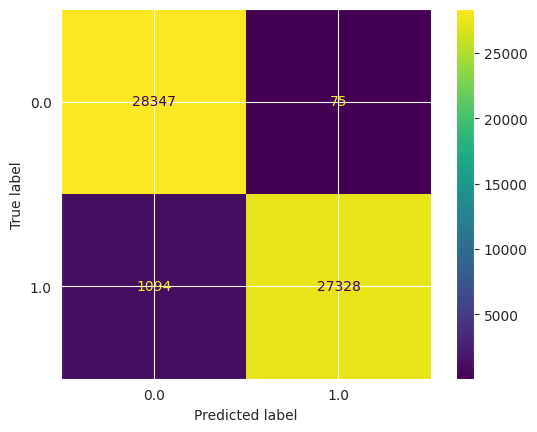

In [136]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_res, y_res, normalize = None)

Finalmente tenemos esta matriz de confusión, donde vemos que 28347 fueron clasificados correctamente como Tweets que no son de odio, y 27328 fueron clasificadas correctamente como tweets con odio. 